In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

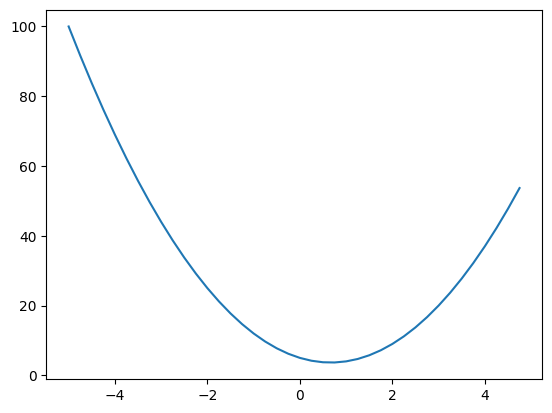

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

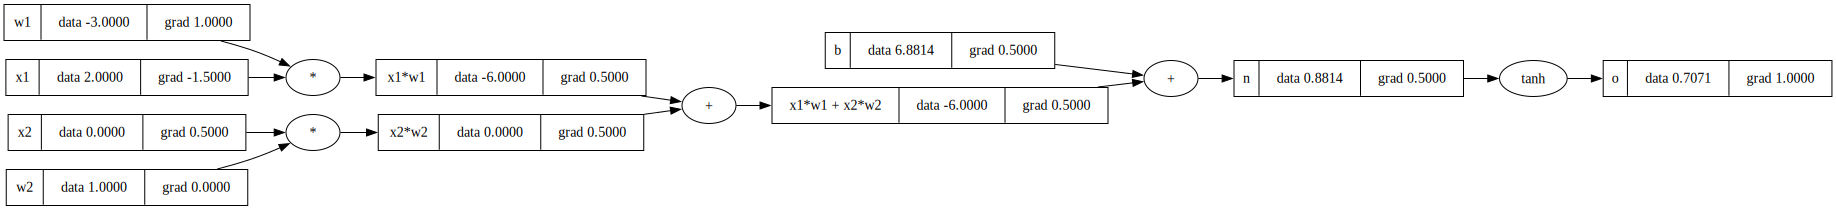

In [11]:
draw_dot(o)

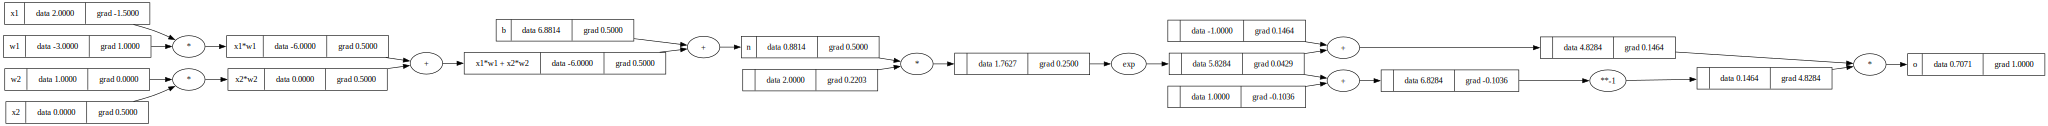

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [13]:
import torch

In [14]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.49492252625501376)

In [17]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [18]:

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 9.054588774681598
1 3.1580775794505622
2 1.383077132803232
3 0.5150822771260746
4 0.24246848761932288
5 0.1494131003164569
6 0.11093136621960842
7 0.08744259156322944
8 0.07174741151141899
9 0.06058301711460036
10 0.05226890679901535
11 0.04585660474152249
12 0.04077246436296972
13 0.03665023237120618
14 0.03324565174713319
15 0.03038988053874929
16 0.02796265186865884
17 0.025876087108480165
18 0.02406454997383559
19 0.022478073346359033


In [19]:
ypred

[Value(data=0.9364425739043991),
 Value(data=-0.9427514765987198),
 Value(data=-0.9064458955410405),
 Value(data=0.9199452497242266)]

In [1]:
import math


class Value:
    def __init__(
        self,
        data: float = 0.0,
        _children: tuple = (),
        _op: str = "",
    ) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.grad = 0.0

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        func = self.data + other.data
        out = Value(data=func, _children=(self, other), _op="+")

        def _derivative():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _derivative
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        func = self.data * other.data
        out = Value(data=func, _children=(self, other), _op="*")

        def _derivative():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _derivative
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), (
            "only supporting int/float powers for now"
        )
        func = self.data**other
        out = Value(data=func, _children=(self,), _op=f"**{other}")

        def _derivative():
            self.grad += (other * self.data ** (other - 1.0)) * out.grad

        out._backward = _derivative
        return out

    def exp(self):
        func = math.exp(self.data)
        out = Value(data=func, _children=(self,), _op="exp")

        def _derivative():
            self.grad += out.data * out.grad

        out._backward = _derivative
        return out

    def tanh(self):
        func = (math.exp(2 * self.data) - 1.0) / (math.exp(2 * self.data) + 1.0)
        out = Value(data=func, _children=(self,), _op="tanh")

        def _derivative():
            self.grad += (1.0 - func**2) * out.grad

        out._backward = _derivative
        return out

    def sigmoid(self):
        func = 1 / (1 + math.exp(-self.data))
        out = Value(data=func, _children=(self,), _op="sigmoid")

        def _derivative():
            self.grad += func * (1.0 - func) * out.grad

        out._backward = _derivative
        return out

    def relu(self):
        func = 0 if self.data <= 0 else self.data
        out = Value(data=func, _children=(self,), _op="relu")

        def _derivative():
            self.grad += 0 * out.grad if self.data < 0 else 1.0 * out.grad

        out._backward = _derivative
        return out

    def leaky_relu(self):
        func = 0.01 * self.data if self.data <= 0 else self.data
        out = Value(data=func, _children=(self,), _op="leaky_relu")

        def _derivative():
            self.grad += 0.01 * out.grad if self.data < 0 else 1.0 * out.grad

        out._backward = _derivative
        return out

    def elu(self, alpha: float = 0.02):
        func = alpha * (math.exp(self.data) - 1.0) if self.data <= 0 else self.data
        out = Value(data=func, _children=(self,), _op="elu")

        def _derivative():
            self.grad += (
                alpha * math.exp(self.data) * out.grad
                if self.data < 0
                else 1.0 * out.grad
            )

        out._backward = _derivative
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(val):
            if val not in visited:
                visited.add(val)
                for child in val._prev:
                    build_topo(child)
                topo.append(val)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


In [2]:
import random
from typing import List


class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []


class Neuron(Module):
    def __init__(self, nin: int = 5, nonlin: bool = True) -> None:
        super().__init__()
        self.w = [Value(data=random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(data=random.uniform(-1, 1))  # 0.0)  #
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # act = reduce(operator.add, (wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self) -> str:
        return f"Neuron(Activation={'ReLU' if self.nonlin else 'Linear'}, Weights={self.w}, Bias={self.b})"


class Layer(Module):
    def __init__(self, nin: int = 5, nout: int = 4, **kwargs) -> None:
        super().__init__()
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def repr(self):
        return f"NN Layer of [{', '.join([str(n) for n in self.neurons])}]"


class MLP(Module):
    def __init__(self, nin: int = 5, nouts: List[int] = [4, 4, 1]) -> None:
        super().__init__()
        sz = [nin] + nouts
        self.layers = [
            Layer(nin=sz[i], nout=sz[i + 1], nonlin=i != len(nouts) - 1)
            for i in range(len(nouts))
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self) -> str:
        return f"MLP of [{', '.join([str(layer) for layer in self.layers])}]"


In [3]:


xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
y_true = [1.0, -1.0, -1.0, 1.0]  # desired targets


nn = MLP(3, [4, 4, 1])
print(len(nn.parameters()))



41


In [4]:

for k in range(100):
    # forward pass
    y_pred = [nn(x) for x in xs]
    loss: Value = sum((yp - yt) ** 2 for yt, yp in zip(y_true, y_pred))

    # backward pass
    # for p in nn.parameters():
    #     p.grad = 0.0
    nn.zero_grad()
    loss.backward()

    # update params
    for p in nn.parameters():
        p.data += -0.025 * p.grad

    print(k, loss.data)

0 8.410124544428854
1 4.1433475345425
2 3.1449114616157967
3 2.594381724933841
4 2.056945497522098
5 1.5886461980115327
6 1.0025640552795414
7 0.6585513108738137
8 0.4046044489814663
9 0.2643472751793308
10 0.24127065014246468
11 0.20469534951224927
12 0.19951251821130284
13 0.25621692464696166
14 0.5011697473959625
15 0.9702195137751486
16 1.9418810005804656
17 1.2989195368645916
18 0.8368419112925766
19 0.2897697591052755
20 0.16626101568080628
21 0.12335853317073085
22 0.10840375370894
23 0.1007929062334772
24 0.09602942412739053
25 0.09235032005952816
26 0.0892744855131946
27 0.08652621709330309
28 0.08399931004408442
29 0.08162256799863535
30 0.07936260088296612
31 0.07719641370345195
32 0.07511169260379655
33 0.07309942121769841
34 0.07115397717482799
35 0.06927079540160519
36 0.06744651184329273
37 0.06567813986212716
38 0.06396318267026882
39 0.06229931985844115
40 0.06068447219302375
41 0.059116674923046425
42 0.05759410881771097
43 0.05611504598516666
44 0.05467786221810435
4